# 1. Análise Exploratória de Dados

In [1]:
# Importando bibliotecas necessárias
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Apenas para ignorar os alertas do python
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definindo a seed para garantir a reprodutibilidade dos resultados
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# Definindo caminho dos dados
dir_path = './CMAPSSData/'
train_file = 'train_FD002.txt'
test_file = 'test_FD002.txt'

# Definindo o nome das colunas para facilitar a exploração dos dados
index_names = ['unidade', 'ciclo_tempo']
setting_names = ['config_1', 'config_2', 'config_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# Lendo os dados
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

# Analisar as primeiras linhas da nossa base de dados
print(train.shape)
train.head()

(53759, 26)


unidade  ciclo_tempo  config_1  config_2  config_3     s_1     s_2  \
0        1            1   34.9983    0.8400     100.0  449.44  555.32   
1        1            2   41.9982    0.8408     100.0  445.00  549.90   
2        1            3   24.9988    0.6218      60.0  462.54  537.31   
3        1            4   42.0077    0.8416     100.0  445.00  549.51   
4        1            5   25.0005    0.6203      60.0  462.54  537.07   

       s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  s_17  \
0  1358.61  1137.23  5.48  ...  183.06  2387.72  8048.56   9.3461  0.02   334   
1  1353.22  1125.78  3.91  ...  130.42  2387.66  8072.30   9.3774  0.02   330   
2  1256.76  1047.45  7.05  ...  164.22  2028.03  7864.87  10.8941  0.02   309   
3  1354.03  1126.38  3.91  ...  130.72  2387.61  8068.66   9.3528  0.02   329   
4  1257.71  1047.93  7.05  ...  164.31  2028.00  7861.23  10.8963  0.02   309   

   s_18    s_19   s_20    s_21  
0  2223  100.00  14.73  8.8071  
1  2212  100.00  10.41  6.2665  
2  1915   84.93  14.08  8.6723  
3  2212  100.00  10.59  6.4701  
4  1915   84.93  14.13  8.5286  

[5 rows x 26 columns]

In [5]:
def add_RUL(df):
    # Obter o numero total de ciclos para cada unidade
    grouped_by_unit = df.groupby(by="unidade")
    max_cycle = grouped_by_unit["ciclo_tempo"].max()
    
    # Mesclar o valor do ciclo maximo no dataframe de origem
    result_frame = df.merge(max_cycle.to_frame(name='ciclo_max'), left_on='unidade', right_index=True)
    
    # Calcular o RUL para cada linha
    remaining_useful_life = result_frame["ciclo_max"] - result_frame["ciclo_tempo"]
    result_frame["RUL"] = remaining_useful_life
    
    # Remover o valor do ciclo maximo, que nao e mais necessario
    result_frame = result_frame.drop("ciclo_max", axis=1)
    return result_frame
  
train = add_RUL(train)
train[index_names+['RUL']].head()

unidade  ciclo_tempo  RUL
0        1            1  148
1        1            2  147
2        1            3  146
3        1            4  145
4        1            5  144

In [6]:
# Verificando as 6 condicoes de operacao
settings_df = train[setting_names].copy()
settings_df['config_1'] = settings_df['config_1'].round()
settings_df['config_2'] = settings_df['config_2'].round(decimals=2)
settings_df.groupby(by=setting_names).size()

config_1  config_2  config_3
0.0       0.00      100.0        8044
10.0      0.25      100.0        8096
20.0      0.70      100.0        8122
25.0      0.62      60.0         8002
35.0      0.84      100.0        8037
42.0      0.84      100.0       13458
dtype: int64

# 2. Gráficos

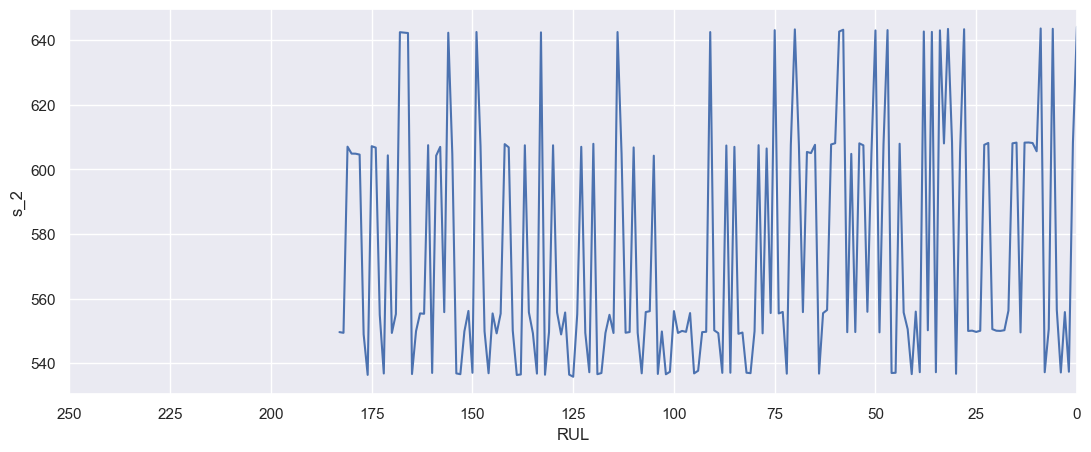

In [7]:
def plot_sinal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unidade']==unit_nr])
    else:
        for i in train['unidade'].unique():
            if (i % 10 == 0):
                plt.plot('RUL', signal_name, 
                         data=df[df['unidade']==i])
    plt.xlim(250, 0)  # Inverte o eixo x para ir de 250 ate 0
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('RUL')
    plt.show()

# Protando apenas o s_2 como exemplo  
plot_sinal(train, 's_2', unit_nr=10) # s_2 vs RUL para unidade 10

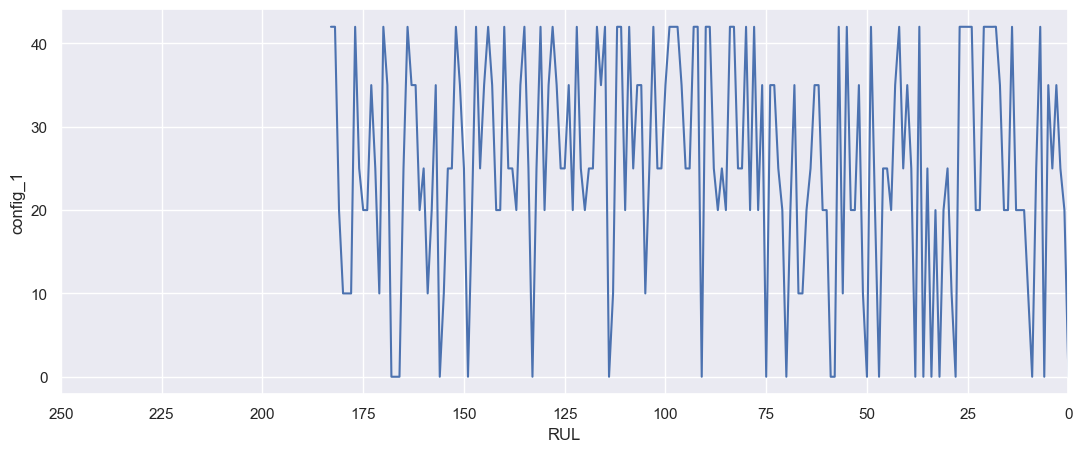

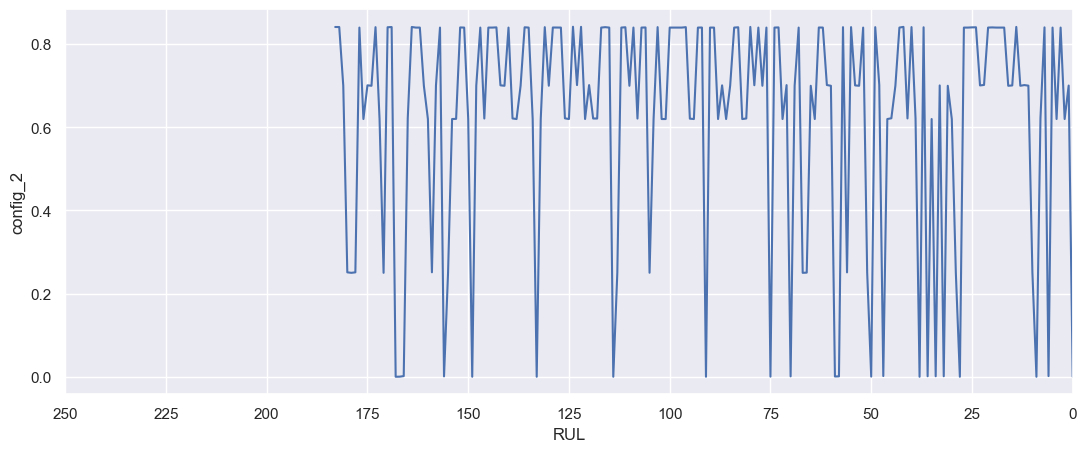

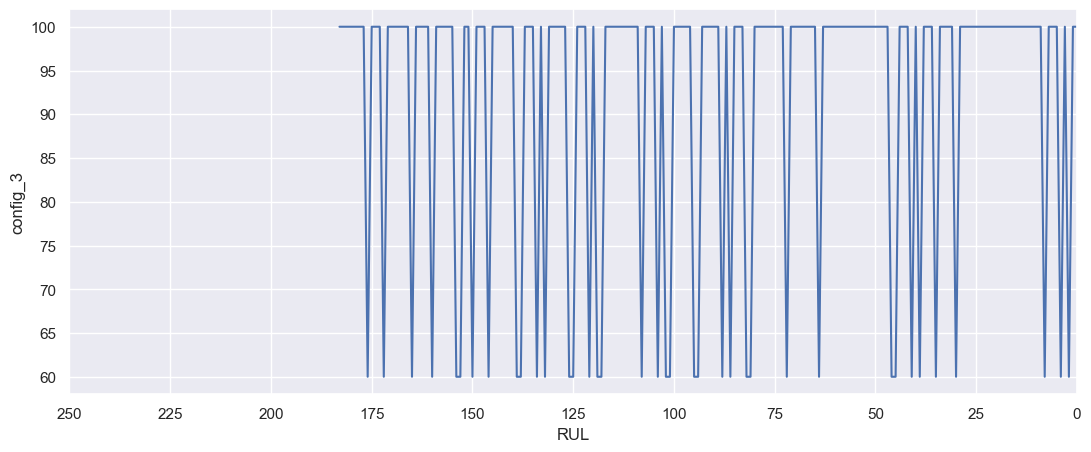

In [8]:
# Plotando as 3 configuracoes para a unidade 10
for setting in setting_names:
    plot_sinal(train, setting, unit_nr=10)

# 3. Modelo de Referência

In [9]:
# Criando a funcao de avaliacao
def avaliar(y_verdadeiro, y_calculado, label='teste'):
    mse = mean_squared_error(y_verdadeiro, y_calculado)
    rmse = np.sqrt(mse)
    variancia = r2_score(y_verdadeiro, y_calculado)
    print('conjunto de {} -> RMSE:{}, R2:{}'.format(label, rmse, variancia))

In [10]:
# Usando uma regressao linear simples como modelo de referencia

# Separando dados de treino
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# Usando apenas a ultima linha para cada unidade para obter o valor real do RUL
X_test = test.drop('ciclo_tempo', axis=1).groupby('unidade').last().copy() 

# Criando e ajustando o modelo
lm = LinearRegression()
lm.fit(X_train, y_train)

# Testando e avaliando o modelo treinado
y_hat_train = lm.predict(X_train)
avaliar(y_train, y_hat_train, 'treino')

y_hat_test = lm.predict(X_test)
avaliar(y_test, y_hat_test)

conjunto de treino -> RMSE:45.0297373781965, R2:0.5763193277684149
conjunto de teste -> RMSE:33.942725282228444, R2:0.6016440598062158


# 4. Conjunto de Validação

In [11]:
# Para obter uma ideia do overfitting antes de executar o modelo com os dados de teste, eh usado um conjunto de validacao

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('unidades_grupo_treino', train.iloc[idx_train]['unidade'].unique(), '\n')
            print('unidades_grupo_validacao', train.iloc[idx_val]['unidade'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train, y_train_clipped, gss, train['unidade'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

unidades_grupo_treino [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

unidades_grupo_validacao [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 

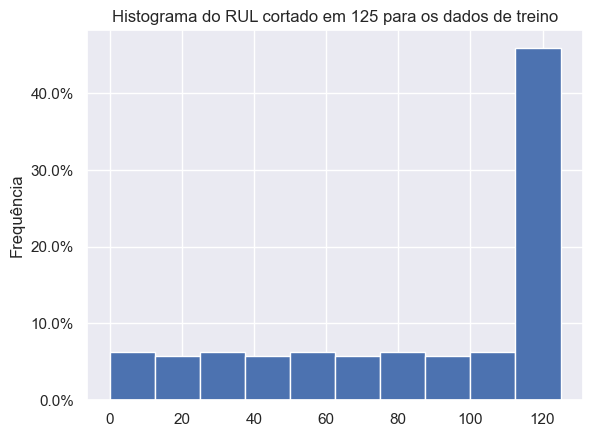

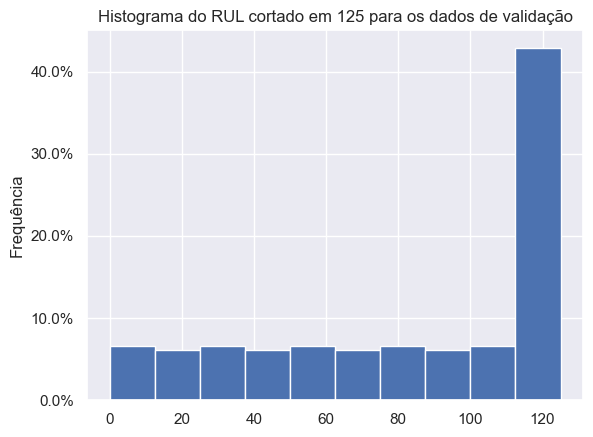

In [12]:
# A distribuicao dos dados de treino deve ser semelhante a distribuicao dos dados de validacao

plt.hist(y_train_clipped_split, weights=np.ones(len(y_train_clipped_split))/len(y_train_clipped_split))
plt.title("Histograma do RUL cortado em 125 para os dados de treino")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Frequência')
plt.show()
plt.close()

plt.hist(y_val_clipped_split, weights=np.ones(len(y_val_clipped_split))/len(y_val_clipped_split))
plt.title("Histograma do RUL cortado em 125 para os dados de validação")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Frequência')
plt.show()
plt.close()

# 5. MLP - 1ª Tentativa

In [13]:
train_cols = setting_names+sensor_names # Dados de entrada
input_dim = len(train_cols) # Dimensao do input do modelo

# Criando a arquitetura da rede neural
model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('initial_weights_simple_mlp.h5')  

epochs = 20

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('initial_weights_simple_mlp.h5') # Salvando os pesos para pode repetir os testes de forma consistente

# Ajustando o modelo
history = model.fit(X_train_split[train_cols], y_train_clipped_split,
                    validation_data=(X_val_split[train_cols], y_val_clipped_split),
                    epochs=epochs)

Epoch 1/20
1359/1359 [==============================] - 7s 3ms/step - loss: 2291.0864 - val_loss: 1753.6213
Epoch 2/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1787.5719 - val_loss: 1780.8635
Epoch 3/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1780.0994 - val_loss: 1752.4713
Epoch 4/20
1359/1359 [==============================] - 5s 3ms/step - loss: 1767.7952 - val_loss: 1739.6646
Epoch 5/20
1359/1359 [==============================] - 5s 3ms/step - loss: 1753.2980 - val_loss: 1762.5205
Epoch 6/20
1359/1359 [==============================] - 5s 3ms/step - loss: 1744.8927 - val_loss: 1865.8798
Epoch 7/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1731.1614 - val_loss: 1794.5032
Epoch 8/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1719.0453 - val_loss: 1699.9773
Epoch 9/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1707.7966 - val_loss: 1712.9940
Epoch 10/20
1359/1359 [=====

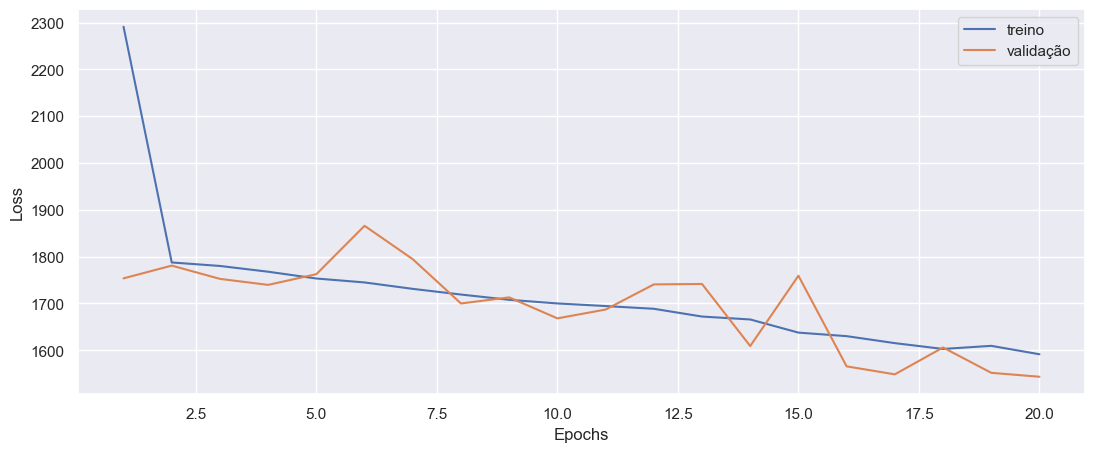

In [14]:
# Plot do historico de treinamento

def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='treino')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validação')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [15]:
# Testando o modelo
y_hat_train = model.predict(X_train[train_cols])
avaliar(y_train_clipped, y_hat_train, 'treino')

y_hat_test = model.predict(X_test[train_cols])
avaliar(y_test, y_hat_test)

1680/1680 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:39.70273905596956, R2:0.0919836016800758
9/9 [==============================] - 0s 1ms/step
conjunto de teste -> RMSE:51.04996797842603, R2:0.09890863620200496


# 6. Normalização dos dados

In [16]:
# Normalizando os dados
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)

# Recriando os grupos de treino e validacao
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unidade'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

unidades_grupo_treino [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

unidades_grupo_validacao [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 

# 7. Perceptron de Múltiplas Camadas (MLP) - Multilayer Perceptron (MLP)

In [17]:
train_cols = setting_names+sensor_names # Dados de entrada
input_dim = len(train_cols) # Dimensao do input do modelo

# Criando a arquitetura da rede neural
model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

epochs = 20

# Ajustando o modelo
history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/20
1359/1359 [==============================] - 5s 3ms/step - loss: 1923.0896 - val_loss: 1824.4563
Epoch 2/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1756.5669 - val_loss: 1692.4890
Epoch 3/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1657.8036 - val_loss: 1629.3785
Epoch 4/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1601.3405 - val_loss: 1606.7770
Epoch 5/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1540.6221 - val_loss: 1538.4363
Epoch 6/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1493.1095 - val_loss: 1586.0635
Epoch 7/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1415.9868 - val_loss: 1429.7296
Epoch 8/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1272.5918 - val_loss: 1167.6193
Epoch 9/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1043.2911 - val_loss: 817.2037
Epoch 10/20
1359/1359 [======

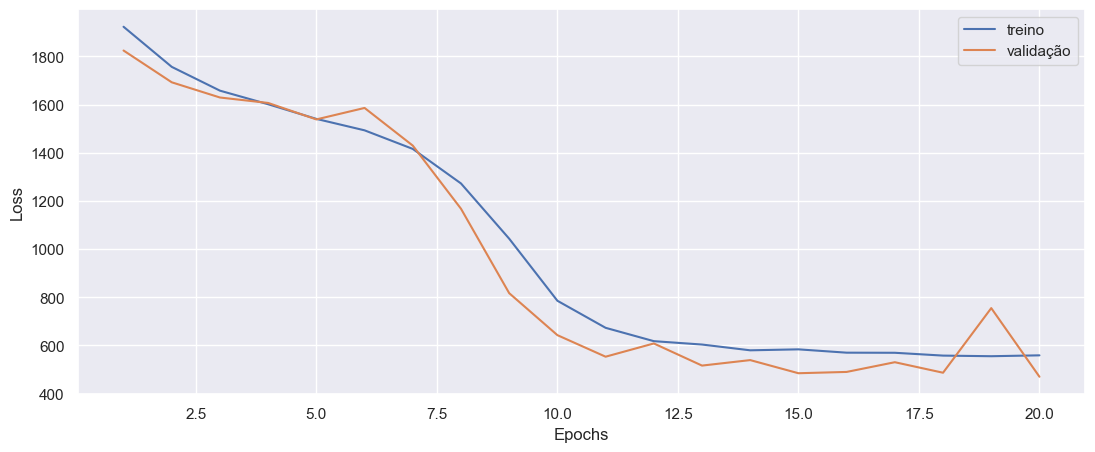

In [18]:
# Plot do historico de treinamento
plot_loss(history)

In [19]:
#Avaliando o modelo
y_hat_train = model.predict(X_train_scaled[train_cols])
avaliar(y_train_clipped, y_hat_train, 'treino')

y_hat_test = model.predict(X_test_scaled[train_cols])
avaliar(y_test, y_hat_test)

1680/1680 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:22.698644031144696, R2:0.7032077328983568
9/9 [==============================] - 0s 2ms/step
conjunto de teste -> RMSE:34.59088799135316, R2:0.5862849675166586


# 8. Normalização baseada na condição de operação

In [20]:
# Listando as condicoes de operacao

# Arredondando os valores para que sejam interpretados como 6 condicoes unicas
X_train_condition = X_train.copy()
X_train_condition['config_1'] = X_train_condition['config_1'].round()
X_train_condition['config_2'] = X_train_condition['config_2'].round(decimals=2)


X_train_condition['op_cond'] = X_train_condition['config_1'].astype(str) + '_' + \
                        X_train_condition['config_2'].astype(str) + '_' + \
                        X_train_condition['config_3'].astype(str)

op_cond = list(X_train_condition['op_cond'].unique())
op_cond

['35.0_0.84_100.0',
 '42.0_0.84_100.0',
 '25.0_0.62_60.0',
 '20.0_0.7_100.0',
 '0.0_0.0_100.0',
 '10.0_0.25_100.0']

In [21]:
# Adicionando a condição de operação ao dataframe
def add_op_cond(df):
    df_op_cond = df.copy()
    
    df_op_cond['config_1'] = df_op_cond['config_1'].round()
    df_op_cond['config_2'] = df_op_cond['config_2'].round(decimals=2)
    
    df_op_cond['op_cond'] = df_op_cond['config_1'].astype(str) + '_' + \
                        df_op_cond['config_2'].astype(str) + '_' + \
                        df_op_cond['config_3'].astype(str)
    
    return df_op_cond

X_train_condition = add_op_cond(train)
X_test_condition = add_op_cond(X_test)

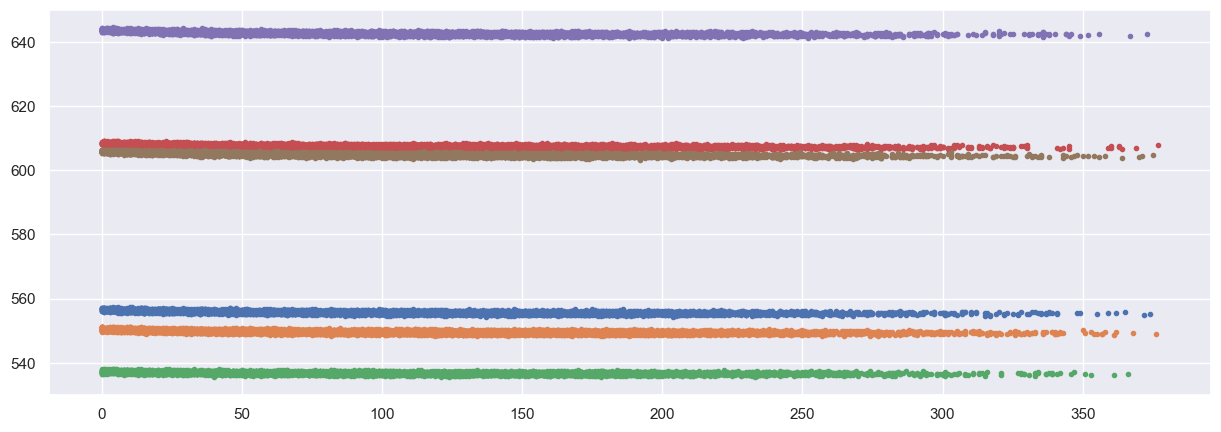

In [22]:
# Grafico de todos os motores para o s_2
# O objetivo eh identificar se as condicoes de operacao sao claramente distinguiveis
plt.figure(figsize=(15,5))

for condition in op_cond:
    data = X_train_condition.loc[X_train_condition['op_cond']==condition]
    plt.plot(data['RUL'], data['s_2'], '.')

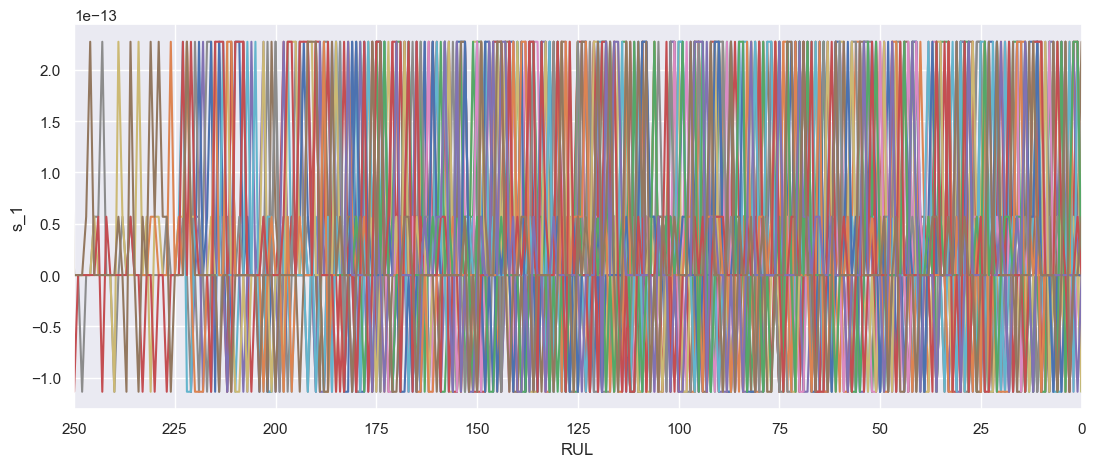

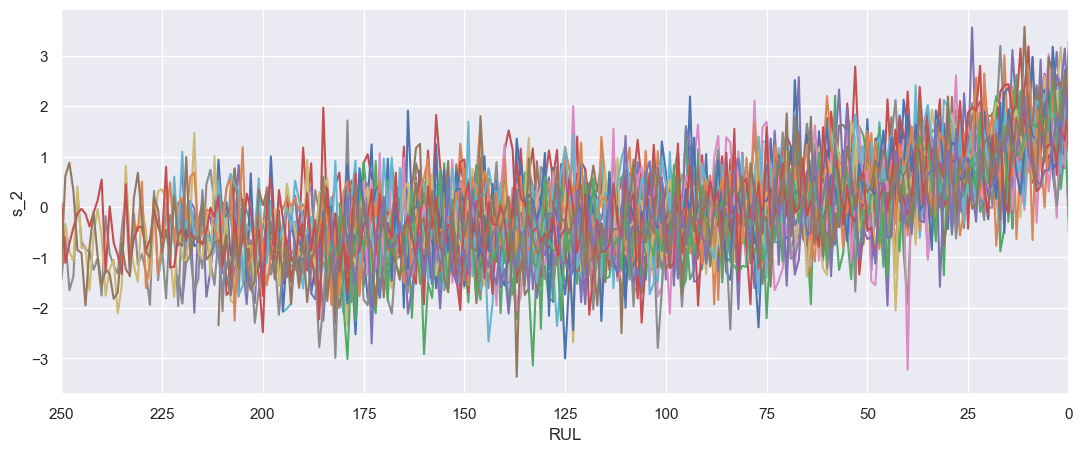

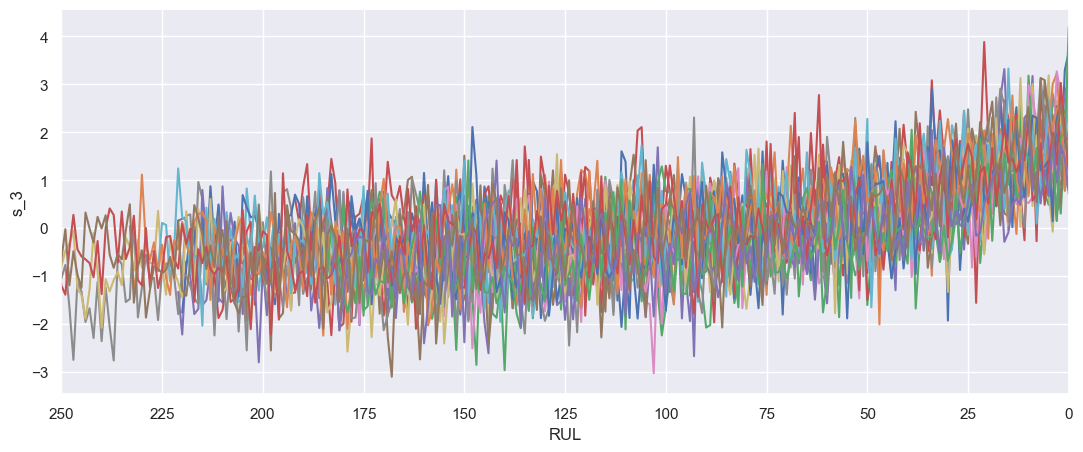

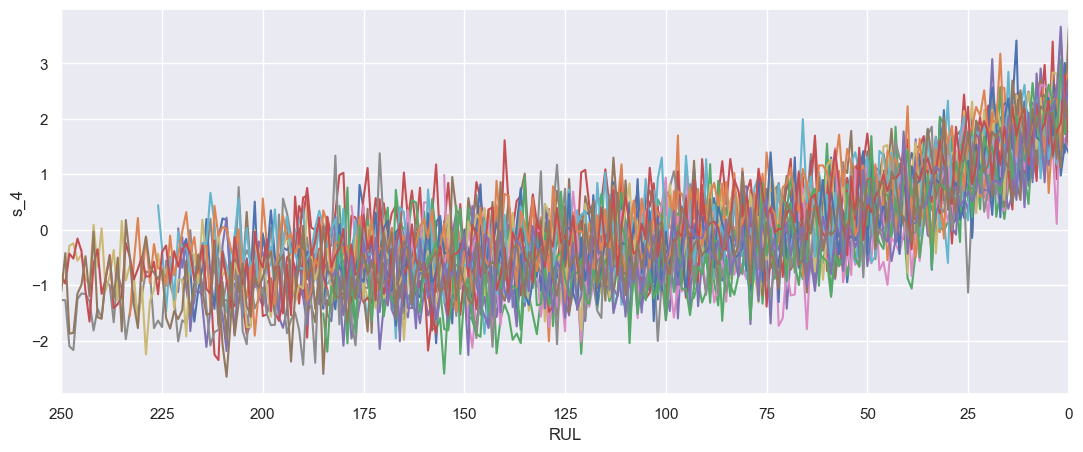

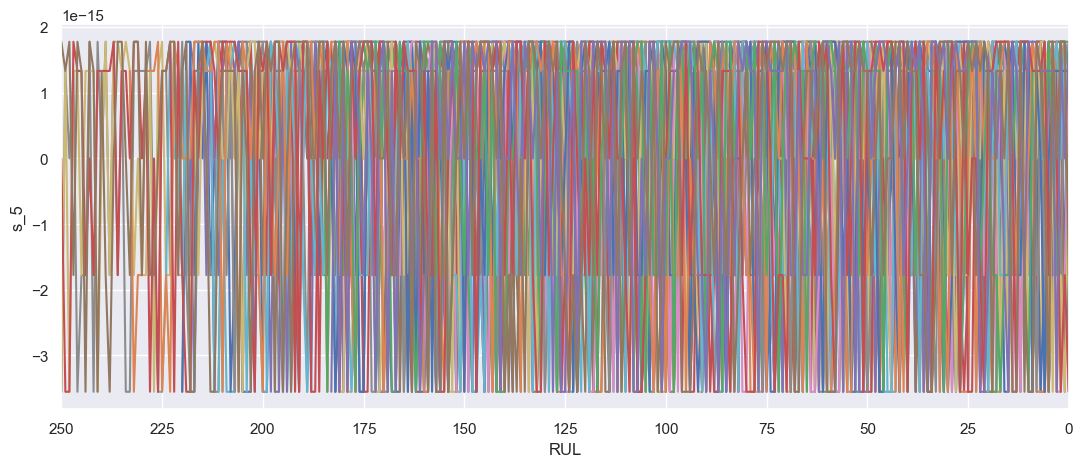

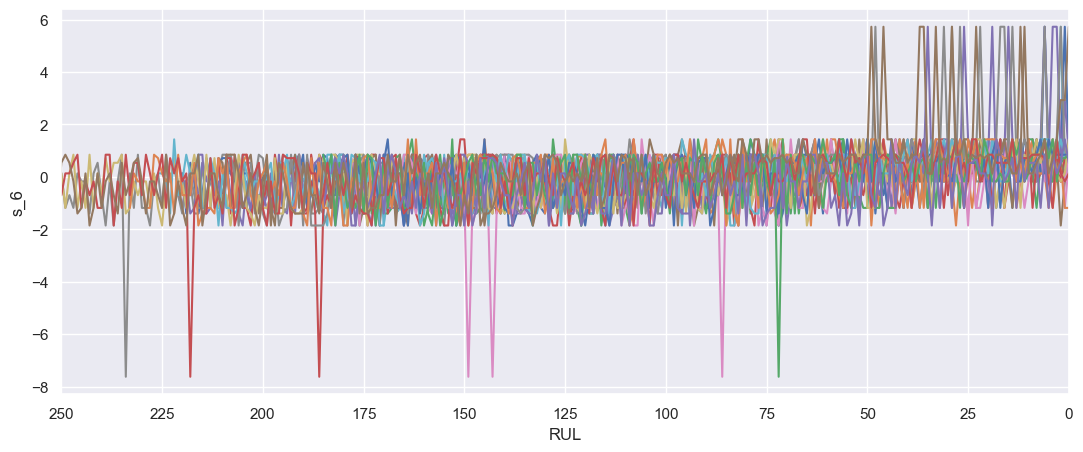

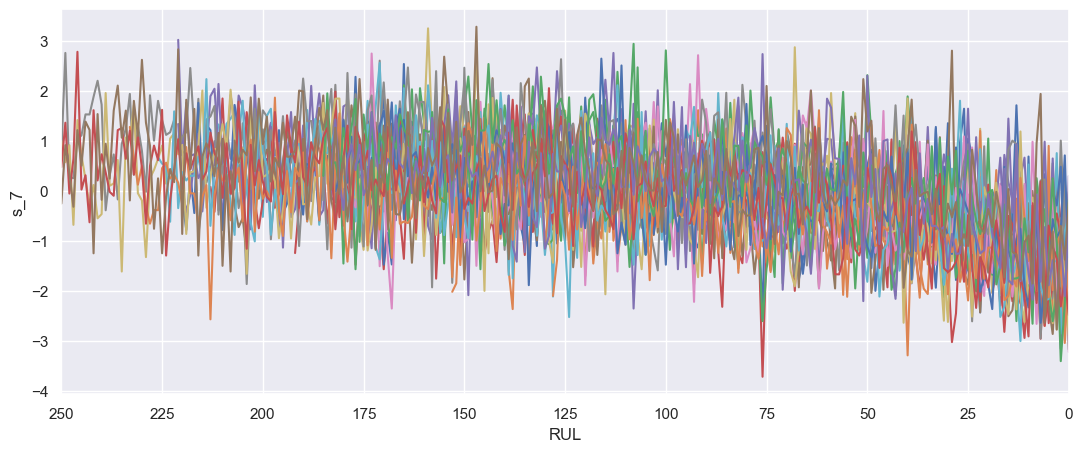

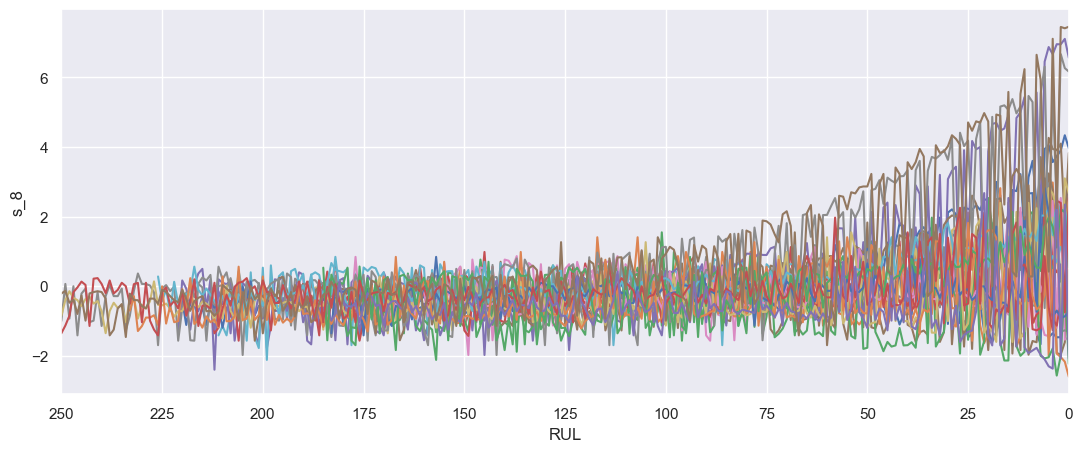

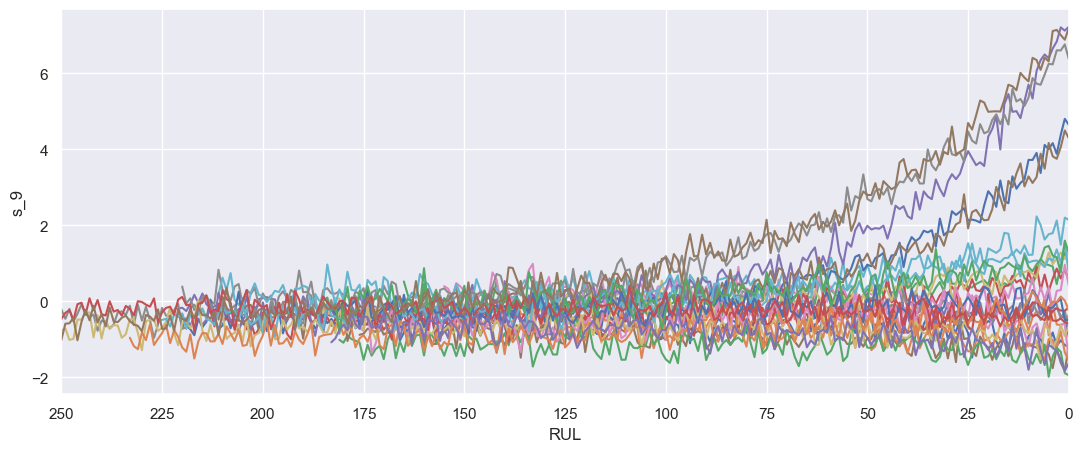

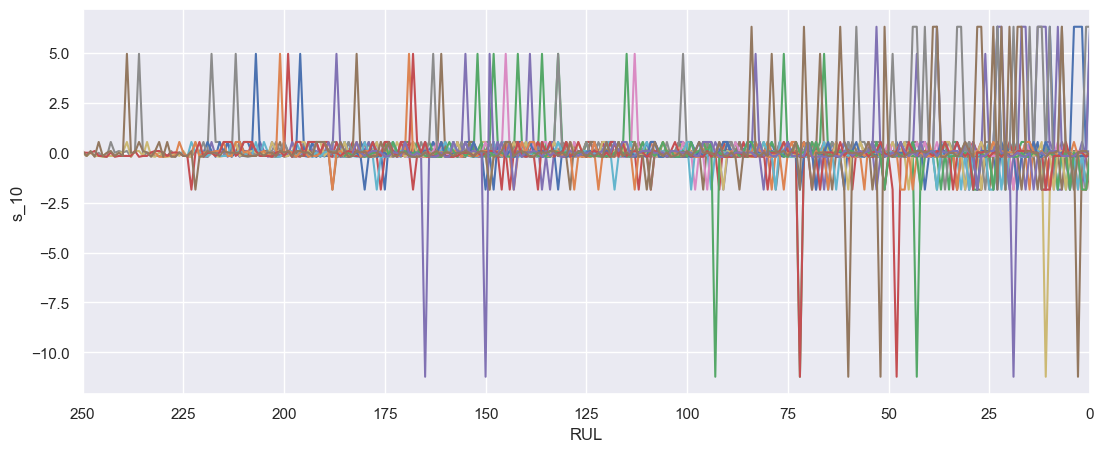

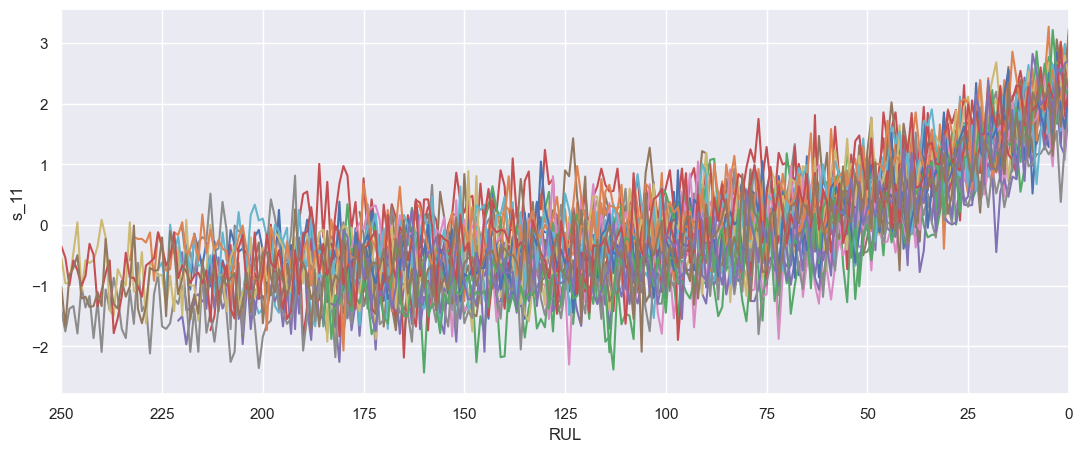

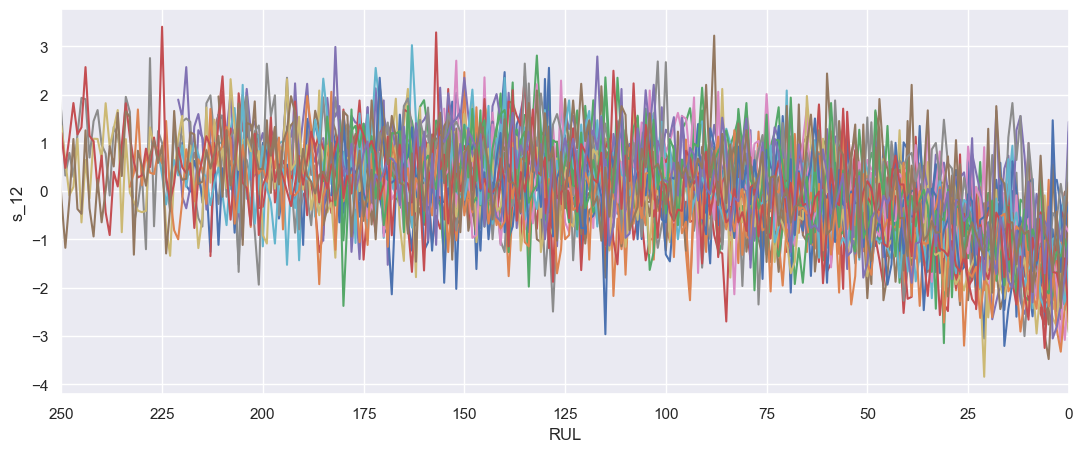

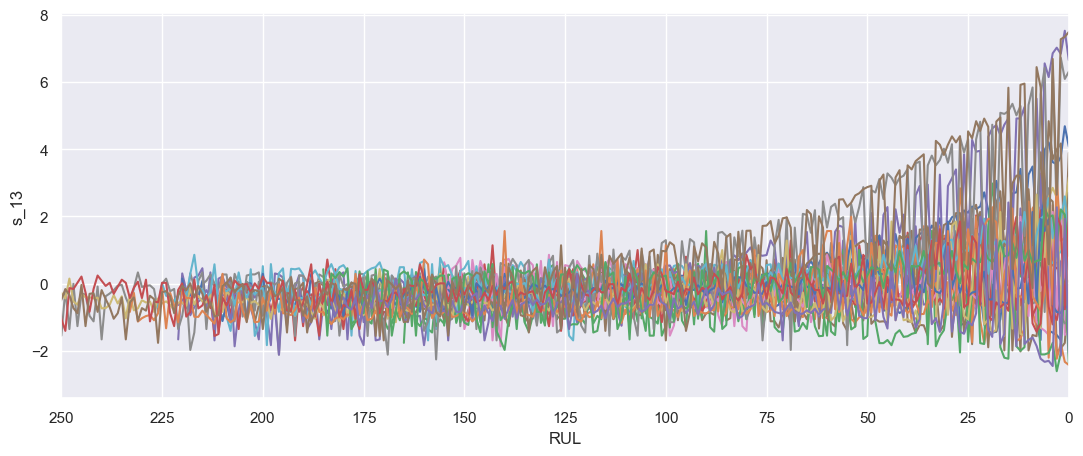

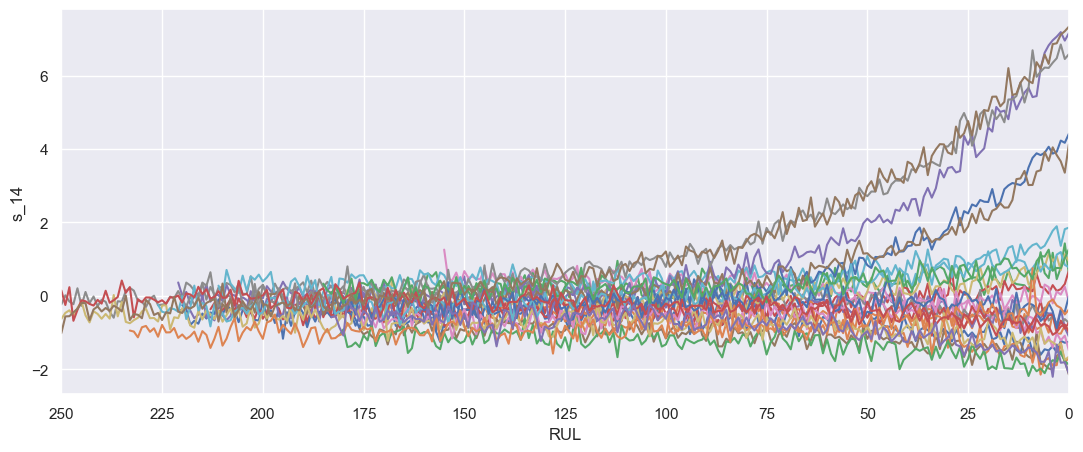

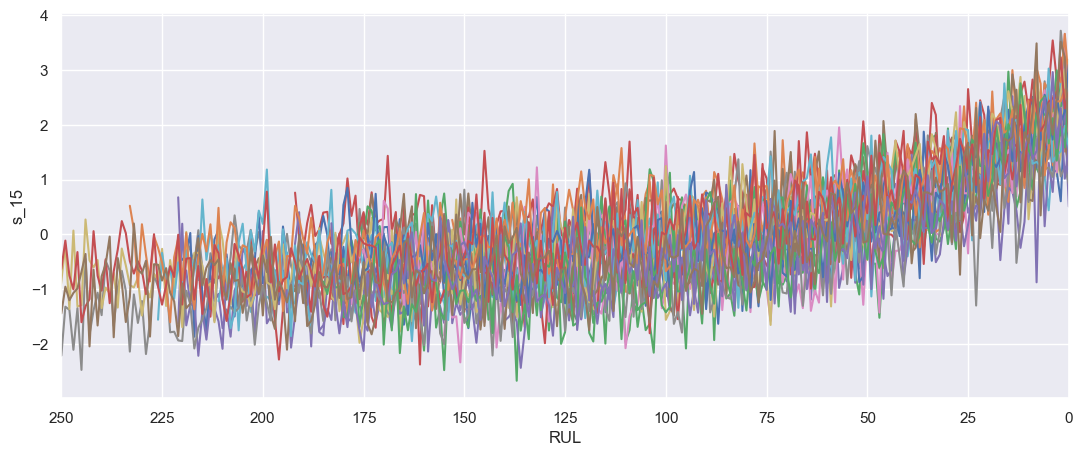

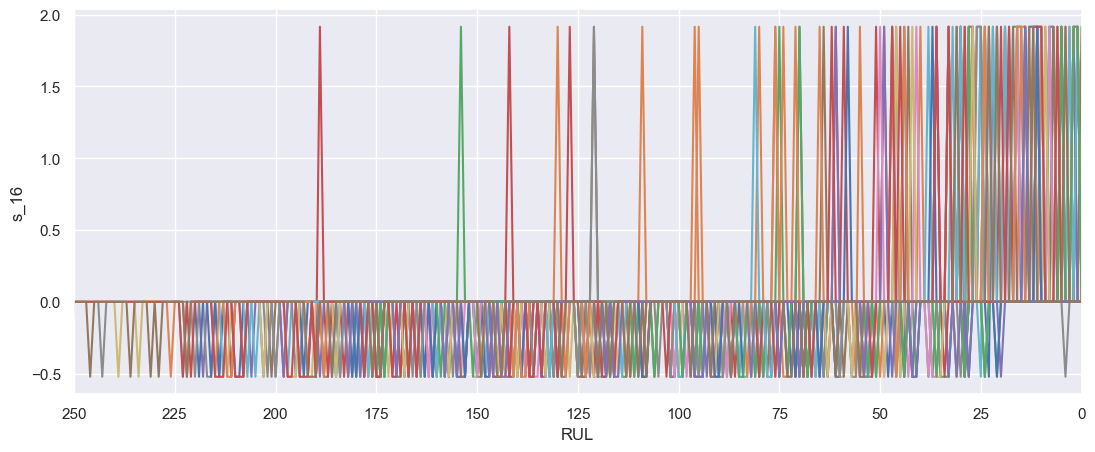

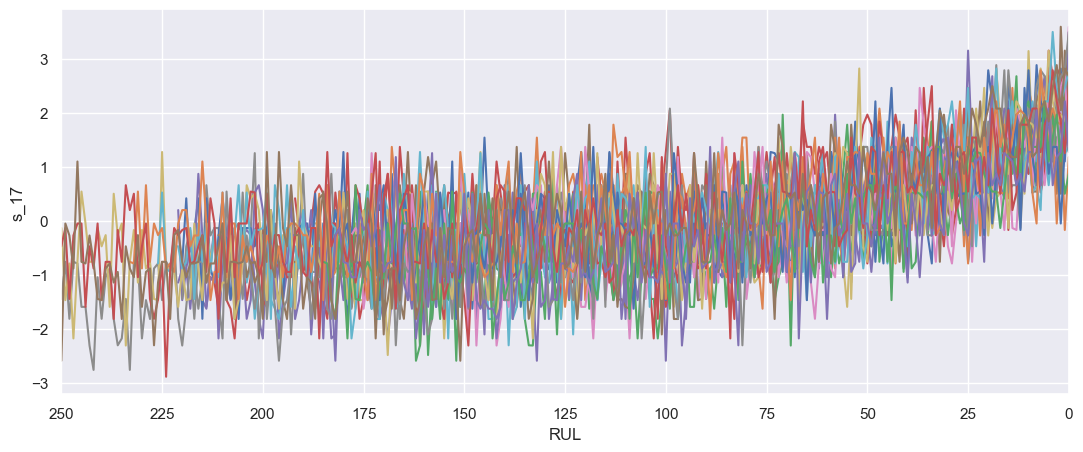

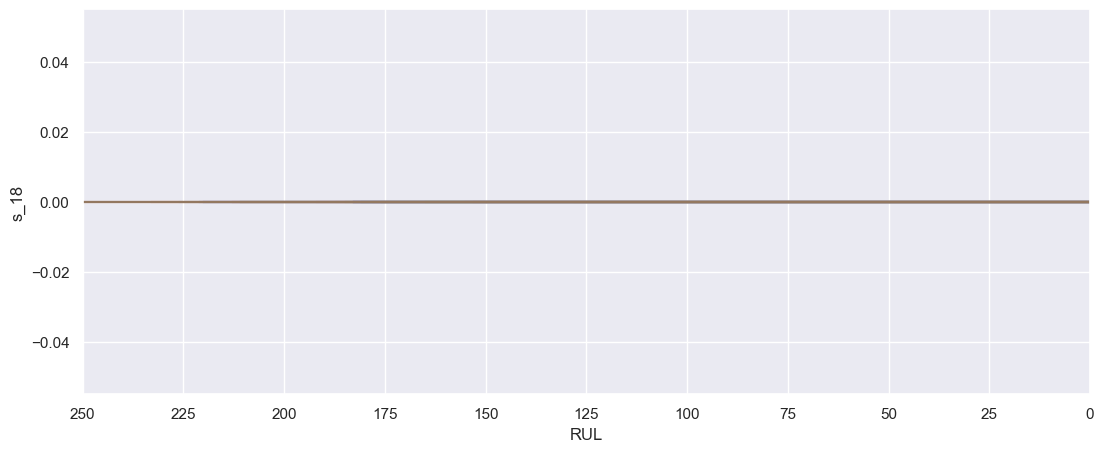

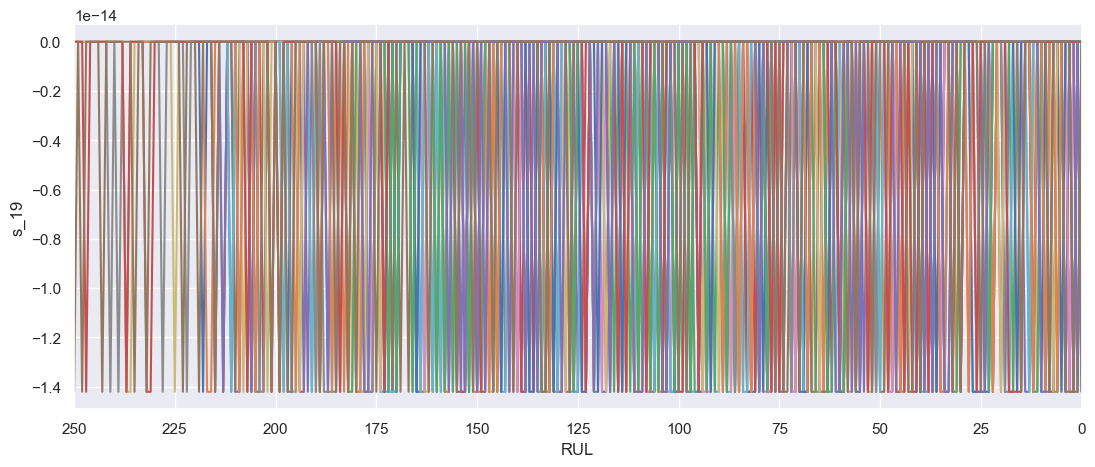

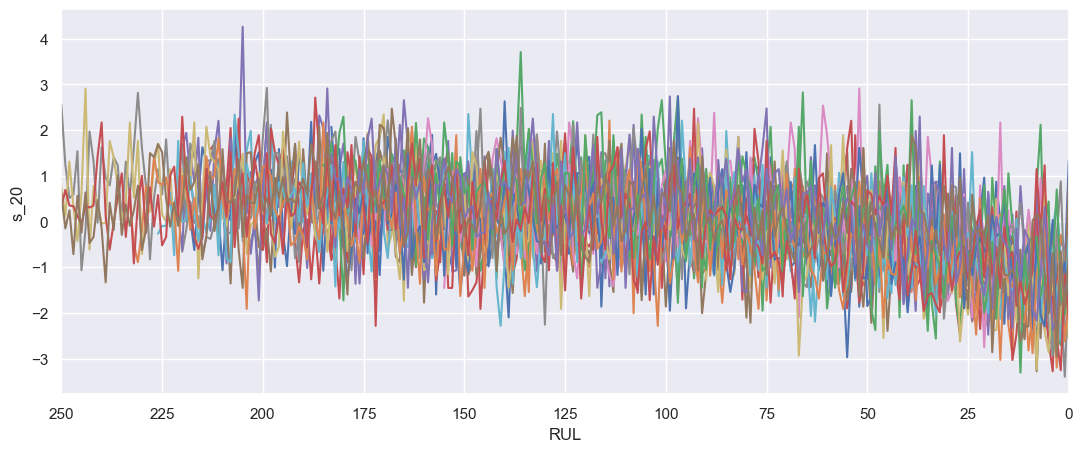

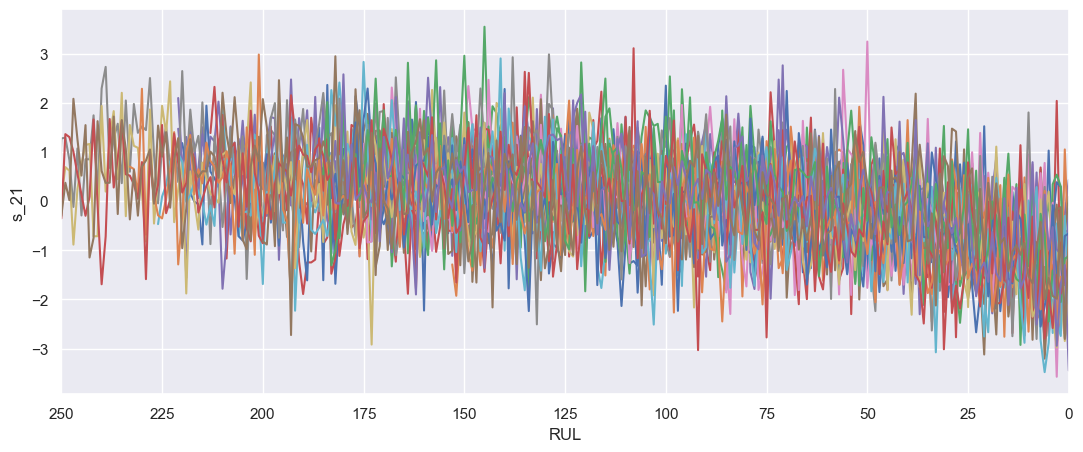

In [23]:
# Normalizando baseado na condicao de operacao

def condition_scaler(df_train, df_test, sensor_names):
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test
  
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)
  
# Plotando o grafico de cada sensor apos a normalizacao por op_cond
for sensor in sensor_names:
    plot_sinal(X_train_condition_scaled, sensor)

In [24]:
# Os sensores uteis sao
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

# Dados desnecessarios
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
drop_sensors

['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

Epoch 1/20
1359/1359 [==============================] - 5s 3ms/step - loss: 1314.9330 - val_loss: 419.7800
Epoch 2/20
1359/1359 [==============================] - 4s 3ms/step - loss: 423.2062 - val_loss: 413.8130
Epoch 3/20
1359/1359 [==============================] - 4s 3ms/step - loss: 402.3065 - val_loss: 394.7578
Epoch 4/20
1359/1359 [==============================] - 4s 3ms/step - loss: 391.6385 - val_loss: 406.6328
Epoch 5/20
1359/1359 [==============================] - 4s 3ms/step - loss: 386.4925 - val_loss: 378.2165
Epoch 6/20
1359/1359 [==============================] - 4s 3ms/step - loss: 384.0962 - val_loss: 423.5373
Epoch 7/20
1359/1359 [==============================] - 4s 3ms/step - loss: 381.6712 - val_loss: 394.4840
Epoch 8/20
1359/1359 [==============================] - 4s 3ms/step - loss: 380.0057 - val_loss: 386.6387
Epoch 9/20
1359/1359 [==============================] - 4s 3ms/step - loss: 379.6298 - val_loss: 378.4733
Epoch 10/20
1359/1359 [======================

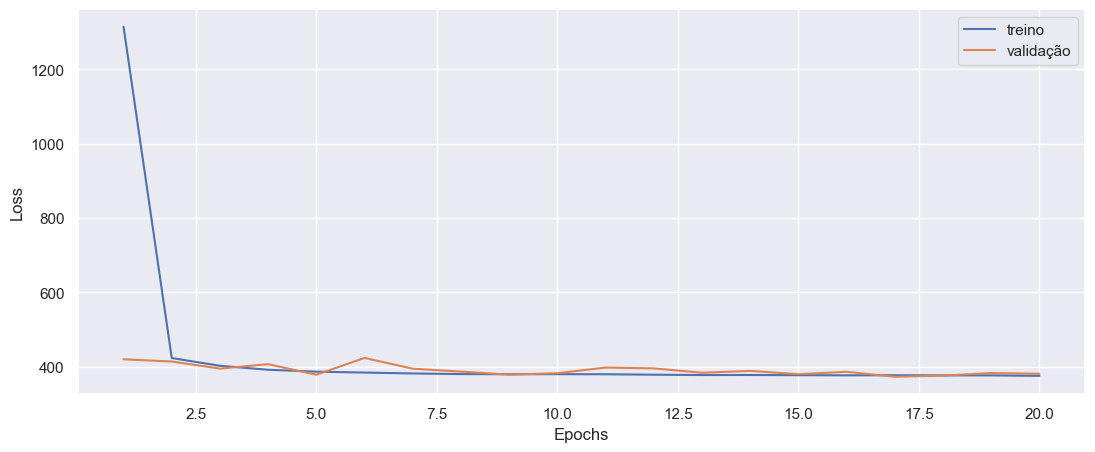

In [25]:
# Ajustando um modelo com as altercoes feitas

split_result = train_val_group_split(X_train_condition_scaled, y_train_clipped, gss, train['unidade'], print_groups=False)
X_train_split_condition_scaled, y_train_clipped_split_condition_scaled = split_result[:2]
X_val_split_condition_scaled, y_val_clipped_split_condition_scaled = split_result[2:]

input_dim = len(X_train_split_condition_scaled[remaining_sensors].columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_split_condition_scaled[remaining_sensors], y_train_clipped_split_condition_scaled,
                    validation_data=(X_val_split_condition_scaled[remaining_sensors], y_val_clipped_split_condition_scaled),
                    epochs=epochs)
plot_loss(history)

In [26]:
# Testando o modelo
y_hat_train = model.predict(X_train_condition_scaled[remaining_sensors])
avaliar(y_train_clipped, y_hat_train, 'treino')

y_hat_test = model.predict(X_test_condition_scaled[remaining_sensors])
avaliar(y_test, y_hat_test)

1680/1680 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:19.32404902096941, R2:0.7848957386939504
9/9 [==============================] - 0s 1ms/step
conjunto de teste -> RMSE:29.39656701632162, R2:0.7012065239530361


# 9. Variáveis defasadas

In [27]:
# De forma semelhante ao que foi feito anteriormente, pode-se adicionar variaveis defasadas para tentar melhorar os resultados do modelo

# Exemplo
np.random.seed(42)
toy_df = pd.DataFrame({'value': np.random.rand(5)})
toy_df['value_lag_1'] = toy_df['value'].shift(1)
toy_df['value_lag_2'] = toy_df['value'].shift(2)
display(toy_df)

value  value_lag_1  value_lag_2
0  0.374540          NaN          NaN
1  0.950714     0.374540          NaN
2  0.731994     0.950714     0.374540
3  0.598658     0.731994     0.950714
4  0.156019     0.598658     0.731994

In [28]:
# Funcao para adicionar as variaveis defasadas de forma especifica
def add_specific_lags(df_input, list_of_lags, columns):
    df = df_input.copy()
    for i in list_of_lags:
        lagged_columns = [col + '_lag_{}'.format(i) for col in columns]
        df[lagged_columns] = df.groupby('unidade')[columns].shift(i)
    df.dropna(inplace=True)
    return df

In [29]:
# Variaveis defasadas que serao inseridas
specific_lags = [1,2,3,4,5,10,20]  # Mesmo conjunto que funcionou bem com o FD001

# Preparando os dados
X_train_condition = add_op_cond(train.drop(drop_sensors, axis=1))
X_test_condition = add_op_cond(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)

X_train_condition_scaled_lagged = add_specific_lags(X_train_condition_scaled, specific_lags, remaining_sensors)
X_test_condition_scaled_lagged = add_specific_lags(X_test_condition_scaled, specific_lags, remaining_sensors)

X_train_condition_scaled_lagged.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1, inplace=True)
X_test_condition_scaled_lagged = X_test_condition_scaled_lagged.drop(['ciclo_tempo', 'op_cond']+setting_names, axis=1).groupby('unidade').last().copy()

idx = X_train_condition_scaled_lagged.index
y_train_clipped_lagged = y_train_clipped.iloc[idx]

split_result = train_val_group_split(X_train_condition_scaled_lagged, y_train_clipped_lagged, gss, train.iloc[idx]['unidade'], print_groups=False)
X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged = split_result[:2]
X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged = split_result[2:]

Epoch 1/20
1229/1229 [==============================] - 5s 4ms/step - loss: 1078.2721 - val_loss: 376.5721
Epoch 2/20
1229/1229 [==============================] - 4s 3ms/step - loss: 370.9327 - val_loss: 344.4439
Epoch 3/20
1229/1229 [==============================] - 4s 3ms/step - loss: 346.0111 - val_loss: 340.9725
Epoch 4/20
1229/1229 [==============================] - 4s 3ms/step - loss: 335.4222 - val_loss: 354.1158
Epoch 5/20
1229/1229 [==============================] - 4s 3ms/step - loss: 328.2882 - val_loss: 329.5356
Epoch 6/20
1229/1229 [==============================] - 4s 3ms/step - loss: 325.4879 - val_loss: 332.0260
Epoch 7/20
1229/1229 [==============================] - 4s 3ms/step - loss: 321.4543 - val_loss: 358.2423
Epoch 8/20
1229/1229 [==============================] - 4s 3ms/step - loss: 319.3615 - val_loss: 318.4034
Epoch 9/20
1229/1229 [==============================] - 4s 3ms/step - loss: 317.6782 - val_loss: 352.9115
Epoch 10/20
1229/1229 [======================

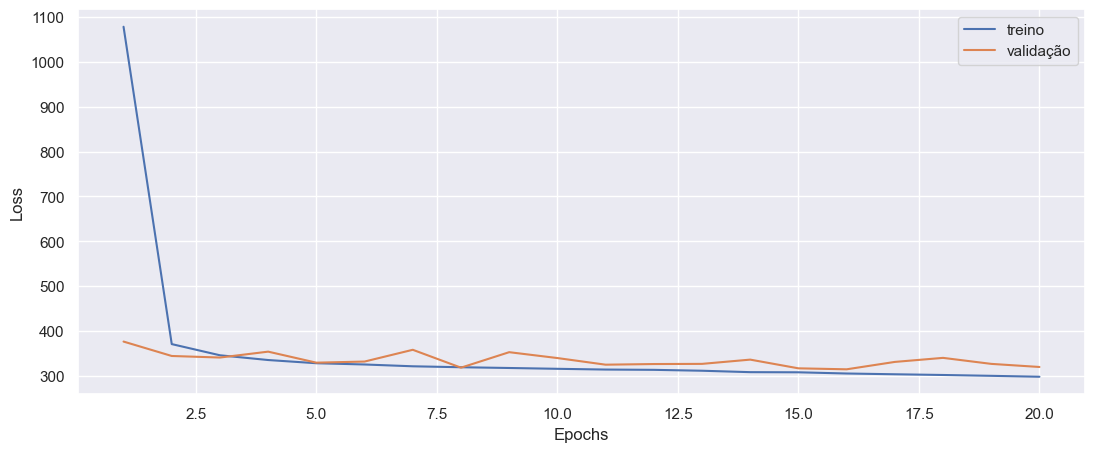

In [30]:
# Criando novamente o modelo com as alteracoes feitas

input_dim = len(X_train_split_condition_scaled_lagged.columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('specific_lagged_weights.h5')

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('specific_lagged_weights.h5')
epochs=20

history = model.fit(X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

plot_loss(history)

In [31]:
# Avaliando o novo modelo
y_hat_train = model.predict(X_train_condition_scaled_lagged)
avaliar(y_train_clipped_lagged, y_hat_train, 'treino')

y_hat_test = model.predict(X_test_condition_scaled_lagged)
avaliar(y_test, y_hat_test)

1518/1518 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:17.206391031817393, R2:0.8308872347146928
9/9 [==============================] - 0s 1ms/step
conjunto de teste -> RMSE:28.309571877992642, R2:0.7228949231237133


# 10. Estacionaridade e Suavização dos dados

In [32]:
# De forma semelhante ao feito com o conjunto FD001, será realizados testes para avaliar a estacionaridade dos dados
# e aplicar processos que garantem a estacionaridade e suavizacao dos dados

from statsmodels.tsa.stattools import adfuller

# Funcao para realizar a diferenciacao dos dados para garantir a estacionaridade
def find_max_diff(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series.diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # Se significante, parar de diferenciar e testar estacionaridade
            do = False
    return maxdiff

# Funcao que torna os dados estacionarios
def make_stationary(df_input, columns):
    df = df_input.copy()
    for unit_nr in range(1, df['unidade'].max()+1):
        for col in columns:
            maxdiff = find_max_diff(df.loc[df['unidade']==unit_nr, col])
            if maxdiff > 0:
                df.loc[df['unidade']==unit_nr, col] = df.loc[df['unidade']==unit_nr, col].diff(maxdiff)
    df.dropna(inplace=True)
    return df

Sinal original é considerado estacionário?  True


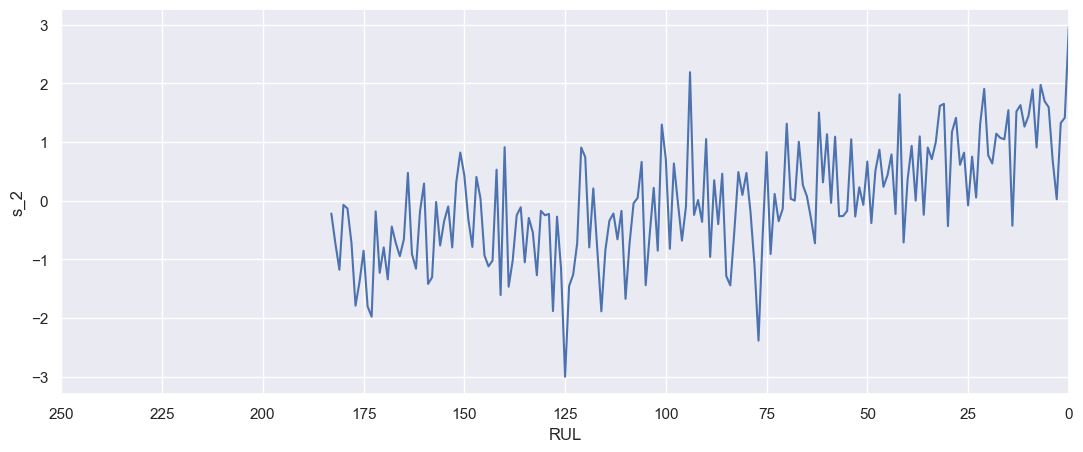

In [33]:
X_train_condition = add_op_cond(train.drop(drop_sensors, axis=1))
X_test_condition = add_op_cond(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, _ = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)


adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                                            X_train_condition_scaled.loc[X_train_condition_scaled['unidade'] == 10,'s_2'], 
                                            maxlag=1)
print('Sinal original é considerado estacionário? ', pvalue < 0.05)
plot_sinal(X_train_condition_scaled, 's_2', 10) # s_2 vs RUL apos normalizacao baseada na op_cond

# 11. Introduzindo suavização aos dados

Sinal suavizado é considerado estacionário?  False


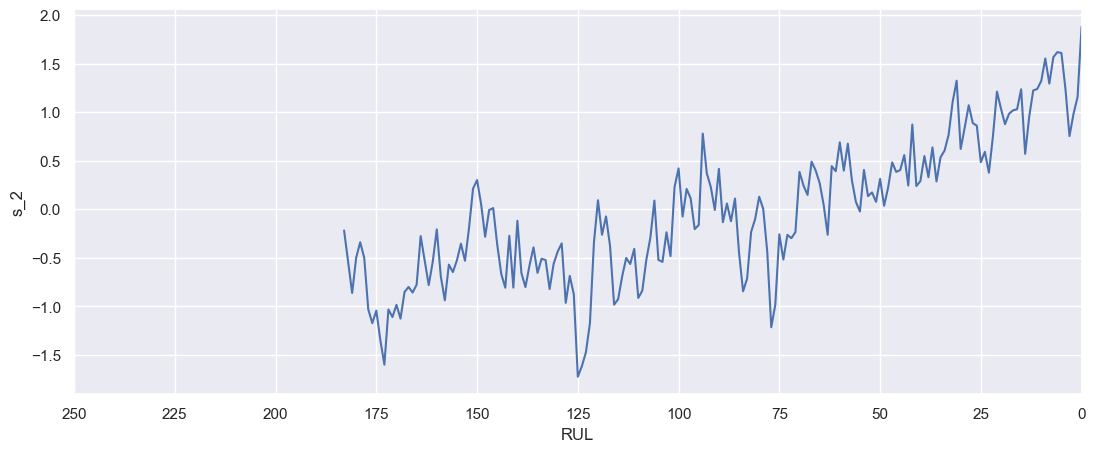

In [34]:
# Valores menores para alpha geram um efeito de filtro maior
X_train_condition_scaled_smoothed = X_train_condition_scaled.copy()

# Agrupa por unidade e separa apenas o sinal dos sensores desejados para aplicar a suavização com a função do Pandas. 
# Depois desfaz o agrupamento e seleciona apenas os valores dos sensores restantes para substituir o valor original.
X_train_condition_scaled_smoothed[remaining_sensors] = X_train_condition_scaled_smoothed.groupby('unidade')[remaining_sensors].ewm(alpha=0.4).mean().reset_index()[remaining_sensors]

# Testando a estacionaridade apos normalizacao baseada na op_cond e suavizacao
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                            X_train_condition_scaled_smoothed.loc[X_train_condition_scaled_smoothed['unidade'] == 10,'s_2'],
                            maxlag=1)
print('Sinal suavizado é considerado estacionário? ', pvalue < 0.05)
plot_sinal(X_train_condition_scaled_smoothed, 's_2', 10)

In [35]:
# Adicionando a suavizacao ao tratamento dos dados
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    df[sensors] = df.groupby('unidade')[sensors].ewm(alpha=0.4).mean().reset_index()[sensors]
    
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unidade')['unidade'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [36]:
# Preparando os dados
X_train_interim = add_op_cond(train.drop(drop_sensors, axis=1))
X_test_interim = add_op_cond(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)

X_train_smooth_lagged = X_train_interim.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1)
X_test_smooth_lagged = X_test_interim.drop(['ciclo_tempo', 'op_cond']+setting_names, 
                                      axis=1).groupby('unidade').last().copy()

idx = X_train_smooth_lagged.index
y_train_clipped_lagged = y_train_clipped.iloc[idx]

# Separando em dados de treino e validacao
split_result = train_val_group_split(X_train_smooth_lagged, y_train_clipped_lagged, gss, train.iloc[idx]['unidade'], print_groups=False)
X_train_split_smooth_lagged, y_train_clipped_split_lagged = split_result[:2]
X_val_split_smooth_lagged, y_val_clipped_split_lagged = split_result[2:]

Epoch 1/20
1229/1229 [==============================] - 4s 3ms/step - loss: 1040.3020 - val_loss: 325.3324
Epoch 2/20
1229/1229 [==============================] - 4s 3ms/step - loss: 313.4390 - val_loss: 286.5516
Epoch 3/20
1229/1229 [==============================] - 4s 3ms/step - loss: 300.6714 - val_loss: 325.9635
Epoch 4/20
1229/1229 [==============================] - 4s 3ms/step - loss: 292.9850 - val_loss: 326.3551
Epoch 5/20
1229/1229 [==============================] - 4s 3ms/step - loss: 284.3202 - val_loss: 279.6228
Epoch 6/20
1229/1229 [==============================] - 4s 3ms/step - loss: 279.3091 - val_loss: 280.9607
Epoch 7/20
1229/1229 [==============================] - 4s 3ms/step - loss: 273.4656 - val_loss: 306.2144
Epoch 8/20
1229/1229 [==============================] - 4s 3ms/step - loss: 270.1501 - val_loss: 279.7643
Epoch 9/20
1229/1229 [==============================] - 4s 3ms/step - loss: 266.4683 - val_loss: 316.7006
Epoch 10/20
1229/1229 [======================

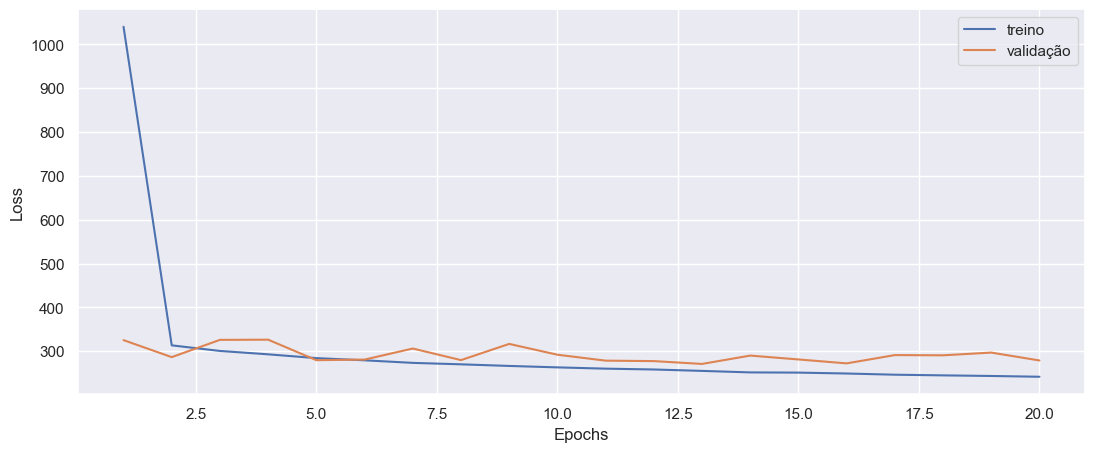

In [37]:
# Criando um novo modelo com as alteracoes feitas
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('specific_lagged_weights.h5')
epochs=20

history = model.fit(X_train_split_smooth_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_smooth_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

plot_loss(history)

In [38]:
# Avaliando o modelo
y_hat_train = model.predict(X_train_smooth_lagged)
avaliar(y_train_clipped_lagged, y_hat_train, 'treino')

y_hat_test = model.predict(X_test_smooth_lagged)
avaliar(y_test, y_hat_test)

1518/1518 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:15.611953941350068, R2:0.8607768880851706
9/9 [==============================] - 0s 1ms/step
conjunto de teste -> RMSE:27.236109576300407, R2:0.7435114249040613


In [39]:
# Usando o mesmo modelo mas testando o efeito de aumentar o numero de epochs
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('specific_lagged_weights.h5')
epochs=50

history = model.fit(X_train_split_smooth_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_smooth_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

Epoch 1/50
1229/1229 [==============================] - 4s 3ms/step - loss: 1040.3920 - val_loss: 325.7291
Epoch 2/50
1229/1229 [==============================] - 4s 3ms/step - loss: 313.8317 - val_loss: 287.9157
Epoch 3/50
1229/1229 [==============================] - 4s 3ms/step - loss: 301.2242 - val_loss: 326.8580
Epoch 4/50
1229/1229 [==============================] - 4s 3ms/step - loss: 293.5153 - val_loss: 324.1941
Epoch 5/50
1229/1229 [==============================] - 4s 3ms/step - loss: 284.8726 - val_loss: 279.7390
Epoch 6/50
1229/1229 [==============================] - 4s 3ms/step - loss: 279.8811 - val_loss: 281.6120
Epoch 7/50
1229/1229 [==============================] - 4s 3ms/step - loss: 274.0380 - val_loss: 304.5072
Epoch 8/50
1229/1229 [==============================] - 4s 3ms/step - loss: 270.7998 - val_loss: 278.2932
Epoch 9/50
1229/1229 [==============================] - 4s 3ms/step - loss: 267.2685 - val_loss: 315.7399
Epoch 10/50
1229/1229 [======================

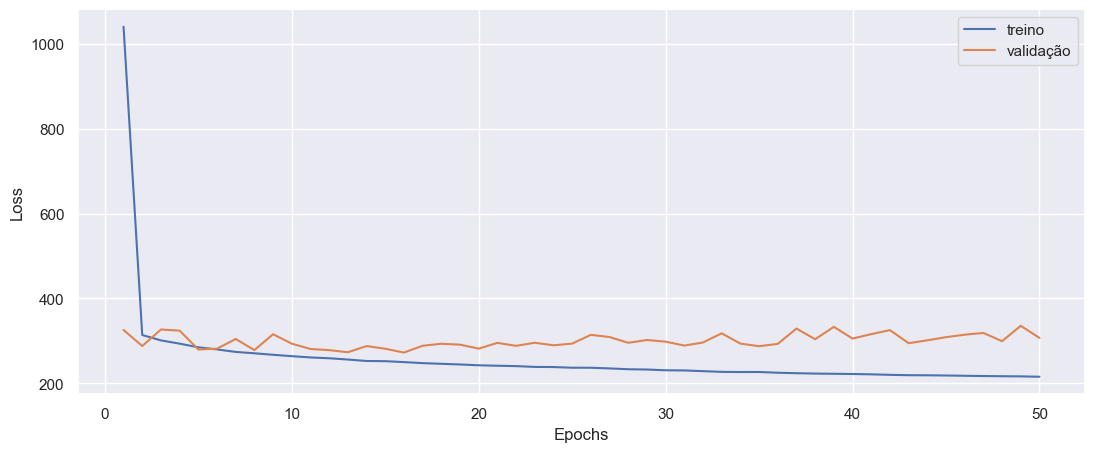

In [40]:
plot_loss(history)

In [41]:
# Avaliando o modelo
y_hat_train = model.predict(X_train_condition_scaled_lagged)
avaliar(y_train_clipped_lagged, y_hat_train, 'treino')

y_hat_test = model.predict(X_test_condition_scaled_lagged)
avaliar(y_test, y_hat_test)

1518/1518 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:19.868374078967854, R2:0.7745130196785124
9/9 [==============================] - 0s 1ms/step
conjunto de teste -> RMSE:30.33883556729192, R2:0.6817446627616286


# 12. Ajuste de hiperparametros

In [42]:
# Definindo os limites de cada parametro para o ajuste de hiperparametros
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)
epoch_list = list(np.arange(10,30+1,5))
nodes_list = [[16, 32, 64], [32, 64, 128], [64, 128, 256], [128, 256, 512]]
dropouts = list(np.arange(1,5)/10)  # O dropout = 0 geraria alguns resultados melhores no treino, mas pior generalização devido ao overfitting
activation_functions = ['tanh', 'sigmoid']  # Testes reveleram que o uso da relu gerava uma performance significativamente pior
batch_size_list = [32, 64, 128, 256, 512]

tuning_options = np.prod([len(alpha_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list)])
tuning_options

6400

In [43]:
# Preparando os dados
def prep_data(df_train, train_label, df_test, remaining_sensors, lags, alpha, n=0):
    X_train_interim = add_op_cond(df_train)
    X_test_interim = add_op_cond(df_test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, n, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, n, alpha)

    X_train_interim = add_specific_lags(X_train_interim, lags, remaining_sensors)
    X_test_interim = add_specific_lags(X_test_interim, lags, remaining_sensors)

    X_train_interim.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1, inplace=True)
    X_test_interim = X_test_interim.drop(
        ['ciclo_tempo', 'op_cond']+setting_names, axis=1).groupby('unidade').last().copy()

    idx = X_train_interim.index
    train_label = train_label.iloc[idx]
    return X_train_interim, train_label, X_test_interim, idx

In [44]:
# Definindo a funcao que vai gerar de forma automatica os modelos a serem testados com os hiperparametros
def create_model(input_dim, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Dense(nodes_per_layer[0], input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_per_layer[1], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_per_layer[2], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [45]:
# Bloco que aplica um conjunto diferente de hiperparametros a cada teste e registra os resultados

import time
import datetime

ITERATIONS = 100

results = pd.DataFrame(columns=['MSE', 'std_MSE',
                                'alpha', 'epochs', 
                                'nodes', 'dropout', 
                                'activation', 'batch_size'])  
weights_file = 'mlp_hyper_parameter_weights.h5'
specific_lags = [1,2,3,4,5,10,20]

time_start = time.time()
print("Início: ", time.ctime(time_start))
time_history = [time_start]
prediction_history = []

for i in range(ITERATIONS):
    
    mse = []
    
    # Parametros de iniciacao
    alpha = random.sample(alpha_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    
    # Criando o dataset
    df_train, train_label, _, idx = prep_data(df_train=train.drop(drop_sensors, axis=1),
                                            train_label=y_train_clipped,
                                            df_test=test.drop(drop_sensors, axis=1), 
                                            remaining_sensors=remaining_sensors,
                                            lags=specific_lags, 
                                            alpha=alpha)
    
    # Criando o modelo
    input_dim = len(df_train.columns)
    model = create_model(input_dim, nodes_per_layer, dropout, activation, weights_file)
    
    
    # Separando em grupos de treino e validacao
    gss_search = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for idx_train, idx_val in gss_search.split(df_train, train_label, groups=train.iloc[idx]['unidade']):
        X_train_split = df_train.iloc[idx_train].copy()
        y_train_split = train_label.iloc[idx_train].copy()
        X_val_split = df_train.iloc[idx_val].copy()
        y_val_split = train_label.iloc[idx_val].copy()
        
        # Treinando e avaliando o modelo
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)
        history = model.fit(X_train_split, y_train_split,
                            validation_data=(X_val_split, y_val_split),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        
        mse.append(history.history['val_loss'][-1])
    
    
    # Registrando os resultados
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size}
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)
    
    
    # Informando previsao ate conclusao
    time_now = time.time()
    time_history.append(time_now)
    
    delta_t = time_now-time_history[i]
    prediction_history.append(delta_t)
    previsao = np.mean(prediction_history)
    
    print("Iteração ", i+1, " de ", ITERATIONS, " concluída em ", datetime.timedelta(seconds=delta_t))
    print("Tempo restante previsto: ", datetime.timedelta(seconds=((previsao)*(ITERATIONS-i+1))))
    print("Previsão para conclusão: ", time.ctime(time.time()+(previsao)*(ITERATIONS-i+1)))
    print()

Início:  Thu May  9 10:50:00 2024
Iteração  1  de  100  concluída em  0:00:56.426863
Tempo restante previsto:  1:34:59.113183
Previsão para conclusão:  Thu May  9 12:25:55 2024

Iteração  2  de  100  concluída em  0:00:27.300640
Tempo restante previsto:  1:09:46.375165
Previsão para conclusão:  Thu May  9 12:01:10 2024

Iteração  3  de  100  concluída em  0:02:22.183797
Tempo restante previsto:  2:04:15.072922
Previsão para conclusão:  Thu May  9 12:58:01 2024

Iteração  4  de  100  concluída em  0:01:49.064136
Tempo restante previsto:  2:16:46.898205
Previsão para conclusão:  Thu May  9 13:12:22 2024

Iteração  5  de  100  concluída em  0:01:48.797311
Tempo restante previsto:  2:23:29.191316
Previsão para conclusão:  Thu May  9 13:20:53 2024

Iteração  6  de  100  concluída em  0:00:29.304610
Tempo restante previsto:  2:06:09.237728
Previsão para conclusão:  Thu May  9 13:04:02 2024

Iteração  7  de  100  concluída em  0:03:42.102999
Tempo restante previsto:  2:37:14.590556
Previsão p

In [46]:
# Ordenando os resultados
sorted_results = results.sort_values('MSE')
sorted_results

MSE     std_MSE  alpha epochs            nodes  dropout  \
68   253.104345   20.779727   0.05     15   [64, 128, 256]      0.1   
32   256.941783   24.376019   0.30     25   [64, 128, 256]      0.1   
97   257.299835   25.120990   0.01     30  [128, 256, 512]      0.4   
2    258.611455   25.146443   0.10     25   [64, 128, 256]      0.3   
94   258.667597   26.853005   0.10     30  [128, 256, 512]      0.4   
..          ...         ...    ...    ...              ...      ...   
28  1979.567993   86.499776   0.01     20     [16, 32, 64]      0.1   
45  2044.520304  104.475759   0.40     10     [16, 32, 64]      0.3   
20  2129.738525  106.586024   0.20     10     [16, 32, 64]      0.3   
93  2354.748942  103.591533   0.01     20     [16, 32, 64]      0.2   
92  3346.966634  134.908594   0.60     10     [16, 32, 64]      0.4   

   activation batch_size  
68       tanh        128  
32       tanh        256  
97       tanh         64  
2        tanh         64  
94       tanh        256  
..        ...        ...  
28    sigmoid        512  
45       tanh        512  
20       tanh        512  
93    sigmoid        512  
92    sigmoid        512  

[100 rows x 8 columns]

# 13. Modelo Final

In [47]:
# Melhores parametros
alpha = float(sorted_results['alpha'].iloc[0])
epochs = int(sorted_results['epochs'].iloc[0])
specific_lags = [1,2,3,4,5,10,20]
nodes = [eval(i) for i in sorted_results['nodes'].iloc[0].replace(" ","").replace("[","").replace("]","").split(",")]
dropout = float(sorted_results['dropout'].iloc[0])
activation = str(sorted_results['activation'].iloc[0])
batch_size = int(sorted_results['batch_size'].iloc[0])

print("Parametros do modelo final:")
print()
print("alpha = ", alpha)
print("epochs = ", epochs)
print("nodes = ", nodes)
print("dropout = ", dropout)
print("activation = ", activation)
print("batch_size = ", batch_size)

Parametros do modelo final:

alpha =  0.05
epochs =  15
nodes =  [64, 128, 256]
dropout =  0.1
activation =  tanh
batch_size =  128


In [48]:
# Preparando os dados
df_train, train_label, df_test, _ = prep_data(df_train=train.drop(drop_sensors, axis=1),
                                        train_label=y_train_clipped,
                                        df_test=test.drop(drop_sensors, axis=1), 
                                        remaining_sensors=remaining_sensors,
                                        lags=specific_lags, 
                                        alpha=alpha)

# Criar e carregar o modelo
input_dim = len(df_train.columns)
weights_file = 'fd002_model_weights.h5'
final_model = create_model(input_dim, 
                           nodes_per_layer=nodes, 
                           dropout=dropout, 
                           activation=activation, 
                           weights_file=weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

In [49]:
# Ajustar o modelo
final_model.fit(df_train, train_label,
               epochs=epochs,
               batch_size=batch_size)

Epoch 1/15
380/380 [==============================] - 2s 4ms/step - loss: 2481.9714
Epoch 2/15
380/380 [==============================] - 1s 3ms/step - loss: 369.0424
Epoch 3/15
380/380 [==============================] - 1s 3ms/step - loss: 304.6990
Epoch 4/15
380/380 [==============================] - 1s 3ms/step - loss: 295.6328
Epoch 5/15
380/380 [==============================] - 1s 3ms/step - loss: 291.0928
Epoch 6/15
380/380 [==============================] - 1s 3ms/step - loss: 288.1507
Epoch 7/15
380/380 [==============================] - 1s 3ms/step - loss: 283.2210
Epoch 8/15
380/380 [==============================] - 1s 3ms/step - loss: 280.4393
Epoch 9/15
380/380 [==============================] - 1s 3ms/step - loss: 275.2265
Epoch 10/15
380/380 [==============================] - 1s 3ms/step - loss: 273.6621
Epoch 11/15
380/380 [==============================] - 1s 3ms/step - loss: 269.0681
Epoch 12/15
380/380 [==============================] - 1s 3ms/step - loss: 267.6496


In [50]:
# Avaliando o modelo
y_hat_train = final_model.predict(df_train)
avaliar(train_label, y_hat_train, 'treino')

y_hat_test = final_model.predict(df_test)
avaliar(y_test, y_hat_test)

1518/1518 [==============================] - 2s 1ms/step
conjunto de treino -> RMSE:15.653736007999846, R2:0.8600306889376979
9/9 [==============================] - 0s 1ms/step
conjunto de teste -> RMSE:27.59700160711759, R2:0.7366691887480761
